## k近邻算法
k近邻(`k-nearest neighbor`, `k-NN`)算法是一种经典的分类算法。k近邻算法根据新的输入实例的k个最近邻实例的类别来决定其分类。所以k近邻算法不像主流的机器学习算法那样有显式的学习训练过程。也正因为如此，k近邻算法的实现和前几章所讲的回归模型略有不同。`k值的选择`、`距离度量方式`以及`分类决策规则`是k近邻算法的三要素。

### 1 距离度量方式
为了衡量特征空间中两个实例之间的相似度，我们用距离(distance)来描述，常用的距离度量方式包括`闵氏距离`和`马氏距离`等。   

(1) `闵氏距离`即`闵可夫斯基距离`(`Minkowski distance`)，该距离定义如下，给定`m`维向量样本集合`X`，对于`xi`，`xj`∈`X`，`xi`=`(x1i,x2i,...xmi)T`，那么样本xi与样本xj的闵氏距离可定义为：
$$ d_{ij}=\left ( \sum_{k=1}^{m}\left | x_{ki}-x_{kj}   \right | ^{p}   \right )^{\frac{1}{p} }, p\ge 1 $$
可以简单看出，当`p=1`时，`闵氏距离`就变成了`曼哈顿距离`(`Manhatan distance`)：
$$ d_{ij}=\sum_{k=1}^{m}\left | x_{ki}-x_{kj}   \right | $$
当`p=2`时，`闵氏距离`就变成了`欧氏距离`(`Euclidean distance`)：
$$ d_{ij}=\left ( \sum_{k=1}^{m}\left | x_{ki}-x_{kj}   \right | ^{2}   \right )^{\frac{1}{2} } $$
当`p=∞`时，`闵氏距离`也称`切比雪夫距离`(`Chebyshev distance`)：
$$ d_{ij}=max\left | x_{ki}-x_{kj}   \right |   $$
(2) `马氏距离`全称`马哈拉诺比斯距离`(`Mahalanobis distance`)，是一种衡量各个特征之间相关性的聚类度量方式。给定一个样本集合`X=(xij)mxn`，假设样本的协方差矩阵为`S`，那么样本xi与样本xj之间的马氏距离可以定义为：
$$ d_{ij}=\left [\left(x_{i}-x_{j}\right)^{T} S^{-1}\left(x_{i}-x_{j}\right)\right] ^{\frac{1}{2}} $$
当`S`为单位矩阵，即样本的各特征之间相互独立且方差为1时，马氏距离就是欧氏距离。

k近邻算法的特征空间是n维实数向量空间，一般直接使用欧氏距离作为实例之间的距离度量。

### 2 k近邻算法的基本原理
给定一个训练集，对于新的输入实例，在训练集中找到与该实例最近邻的k个实例，这k个实例的多数属于哪个类，则该实例就属于哪个类。故总结出几个关键点：

- 找到与该实例最近邻的实例，这里涉及如何找，一般使用欧氏距离。
- k个实例，k的大小如何选择。
- k个实例的多数属于哪个类，一般选取多数表决的归类规则。

三个关键点中还需要重视的是k值的选择，k值较少时，预测结果会对实例非常敏感，分类器抗噪能力差，容易产生过拟合；如果k值较大相应的分类误差会增大，模型整体变简单，产生一定程度上的欠拟合。一般采用交叉验证的方式来选择合适的k值。

**knn**与**k-means**   
`k近邻法`(`knn`)是一种基本的分类与回归方法。   
`k-means`是一种简单有效的聚类方法。

### 3 基于numpy的k近邻算法实现

定义新的样本实例与训练样本之间的欧式距离函数

In [11]:
import numpy as np

# 定义欧式距离函数
def compute_distances(X_test, X_train): # 测试样本实例矩阵，训练样本实例矩阵

    num_test = X_test.shape[0] # 45
    num_train = X_train.shape[0] # 105
    dists = np.zeros((num_test, num_train)) # 基于训练和测试维度的欧式距离初始化 45*105
    M = np.dot(X_test, X_train.T) # 测试样本与训练样本的矩阵点乘 45*105
    te = np.square(X_test).sum(axis=1) # 测试样本矩阵平方 45*feature_dim
    tr = np.square(X_train).sum(axis=1) # 训练样本矩阵平方 105*feature_dim
    dists = np.sqrt(-2 * M + tr + np.matrix(te).T) # 计算欧式距离，广播
    return dists # 欧氏距离

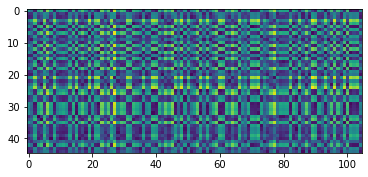

In [14]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle

# 加载鸢尾花数据集
iris = datasets.load_iris() # 加载鸢尾花数据集
X, y = shuffle(iris.data, iris.target, random_state=13) # 打乱数据
X = X.astype(np.float32)

offset = int(X.shape[0] * 0.7)
X_train, y_train, X_test, y_test = X[:offset], y[:offset], X[offset:], y[offset:]
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

dists = compute_distances(X_test, X_train)
plt.imshow(dists, interpolation='none')
plt.show()

标签预测函数，包含默认k值和分类决策规则

In [19]:
from collections import Counter

# 标签预测函数
def predict_labels(y_train, dists, k=1): # 训练集标签, 测试集与训练集的欧氏距离, k值

    num_test = dists.shape[0] # 测试样本量
    y_pred = np.zeros(num_test) # 初始化测试集预测结果
    for i in range(num_test):
        closest_y = [] # 初始化最近邻列表
        # 按欧式距离矩阵排序后取索引，并用训练集标签按排序后的索引取值，最后展开列表
        labels = y_train[np.argsort(dists[i, :])].flatten() # argsort函数返回的是数组值从小到大的索引值
        closest_y = labels[0:k] # 取最近的k个值进行计数统计
        c = Counter(closest_y) # Counter
        y_pred[i] = c.most_common(1)[0][0] # 取计数最多的那个类别
    return y_pred # 测试集预测结果

In [39]:
# 尝试对测试集进行预测，在默认k值取1的情况下，观察分类准确率
y_test_pred = predict_labels(y_train, dists, k=10)
y_test_pred = y_test_pred.reshape(-1, 1)
num_correct = np.sum(y_test_pred == y_test) # 找出预测正确的实例
accuracy = float(num_correct / y_test.shape[0])
print(accuracy)

0.9777777777777777


为了找出最优k值，我们尝试使用五折交叉验证的方式进行搜寻

In [30]:
from sklearn.metrics import accuracy_score

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
k_to_accuracies = dict()

for k in k_choices:
    for fold in range(num_folds):
        # 为传入的训练集单独划分出一个验证集作为测试集
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])
        temp_dists = compute_distances(validation_X_test, temp_X_train)
        temp_y_test_pred = predict_labels(temp_y_train, temp_dists, k)
        temp_y_test_pred = temp_y_test_pred.reshape(-1, 1)
        accuracy = accuracy_score(temp_y_test_pred, validation_y_test)
        k_to_accuracies[k] = k_to_accuracies.get(k, []) + [accuracy]
    
for k in k_to_accuracies:
    for accuracy in k_to_accuracies[k]:
        print(f'k = {k}, accuracy = {accuracy}')

k = 1, accuracy = 0.9047619047619048
k = 1, accuracy = 1.0
k = 1, accuracy = 0.9523809523809523
k = 1, accuracy = 0.8571428571428571
k = 1, accuracy = 0.9523809523809523
k = 3, accuracy = 0.8571428571428571
k = 3, accuracy = 1.0
k = 3, accuracy = 0.9523809523809523
k = 3, accuracy = 0.8571428571428571
k = 3, accuracy = 0.9523809523809523
k = 5, accuracy = 0.8571428571428571
k = 5, accuracy = 1.0
k = 5, accuracy = 0.9523809523809523
k = 5, accuracy = 0.9047619047619048
k = 5, accuracy = 0.9523809523809523
k = 8, accuracy = 0.9047619047619048
k = 8, accuracy = 1.0
k = 8, accuracy = 0.9523809523809523
k = 8, accuracy = 0.9047619047619048
k = 8, accuracy = 0.9523809523809523
k = 10, accuracy = 0.9523809523809523
k = 10, accuracy = 1.0
k = 10, accuracy = 0.9523809523809523
k = 10, accuracy = 0.9047619047619048
k = 10, accuracy = 0.9523809523809523
k = 12, accuracy = 0.9523809523809523
k = 12, accuracy = 1.0
k = 12, accuracy = 0.9523809523809523
k = 12, accuracy = 0.8571428571428571
k = 12, 

不同k值下的分类准确率

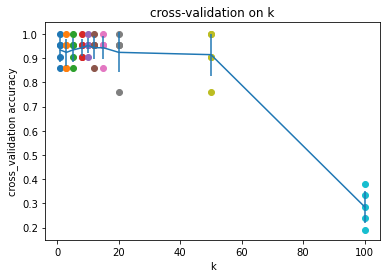

In [26]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)
accuracies_mean = np.array([np.mean(v) for k, v in k_to_accuracies.items()]) # 计算标准差
accuracies_std = np.array([np.std(v) for k, v in k_to_accuracies.items()]) # 计算方差
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std) # 误差棒图 
plt.title('cross-validation on k')
plt.xlabel('k')
plt.ylabel('cross_validation accuracy')
plt.show()

### 4 基于sklearn的k近邻算法实现

In [32]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.9777777777777777


d:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
